<center>

| Nazwa przedmiotu                          | Dataset                                |
| ----------------------------------------- | -------------------------------------- |
| Projekt zespołowy - sztuczna inteligencja | laptop_prices_dataset                  |
|                                           |                                        |
| Piotr                                     | Goraj                                  |
| Numer albumu                              | 55529                                  |
|                                           |                                        |
| Bartosz                                   | Kiałka                                 |
| Numer albumu                              | 55528                                  |
|                                           |                                        |
| Data oddania sprawozdania                 | 2024.11.16                             |
| Kierunek                                  | Informatyka, II stopnia P, Stacjonarne |

</center>


Nazwa przedmiotu: Projekt zespołowy - sztuczna inteligencja

Kierunek: Informatyka, II stopnia P, Stacjonarne

Dataset: laptop_prices_dataset https://www.kaggle.com/datasets/owm4096/laptop-prices/data



Autorzy:

Piotr Goraj, nr. alb. 55529

Bartosz Kiałka, nr. alb. 55528



Data oddania sprawozdania: 2024.11.16

## 1. Instalacja i import bibliotek

In [ ]:
# !pip install pandas
# !pip install scikit-learn
# !pip install numpy
# !pip install shap
# !pip install matplotlib
# !pip install seaborn
# !pip install --upgrade shap scikit-learn pandas numpy matplotlib

# !pip install --upgrade shap scikit-learn pandas numpy matplotlib
# !pip install --upgrade shap
# !pip install --upgrade matplotlib seaborn scikit-learn

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
import seaborn as sns


C:\Users\pgora\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Odczyt danych do modelu

In [2]:
TRAIN_FILE_PATH = './train_data.csv'
VAL_FILE_PATH = './val_data.csv'
TEST_FILE_PATH = './test_data.csv'

train_model_data = pd.read_csv(TRAIN_FILE_PATH)
val_model_data = pd.read_csv(VAL_FILE_PATH)
test_model_data = pd.read_csv(TEST_FILE_PATH)

## 3. Model predykcyjny - Regresja

#### Kluczowe pojęcia:

  - Hiperparametry: Są to parametry, które musisz ustawić przed rozpoczęciem treningu modelu (np. wartość współczynnika regularizacji w Lasso). Różnią się od parametrów modelu, które są wyznaczane podczas treningu (np. współczynniki w regresji liniowej).

  - Grid Search/Random Search: Techniki przeszukiwania przestrzeni hiperparametrów w celu znalezienia najlepszych ustawień. Grid Search testuje wszystkie kombinacje, a Random Search losowo wybiera kombinacje.

  - Skalowanie danych (MinMaxScaler): Przekształca dane tak, aby mieściły się w określonym przedziale (zwykle od 0 do 1). Jest to ważne, ponieważ wiele algorytmów (w tym regresja) działa lepiej, gdy cechy są na tej samej skali.

In [3]:
# podział na cechy (X) oraz etykiety (y)
X_train = train_model_data.drop(columns=['Price_euros'])  
y_train = train_model_data['Price_euros']

X_val = val_model_data.drop(columns=['Price_euros'])
y_val = val_model_data['Price_euros']

X_test = test_model_data.drop(columns=['Price_euros'])
y_test = test_model_data['Price_euros']

# połączenie zbioru treningowego i walidacyjnego
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# ujednolicenie kolumn i ich kolejności
def align_and_sort_columns(train, test):
    all_columns = train.columns.tolist()
    for col in all_columns:
        if col not in test.columns:
            test[col] = 0
    return train, test[all_columns]

X_train_combined, X_test = align_and_sort_columns(X_train_combined, X_test)

# skalowanie danych
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test) # Użycie fit_transform tylko na danych treningowych

In [4]:
# regresja liniowa i Lasso
linear_model = LinearRegression()
lasso_model = Lasso()

In [5]:
# optymalizacja hiperparametrów dla Lasso
## Hiperparametr alpha kontroluje siłę regularizacji
''' czym są hiperparametry? '''
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  

grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search_lasso.fit(X_train_scaled, y_train_combined)

# najlepszy model Lasso
## best_estimator_ - to atrybut GridSearchCV, który przechowuje najlepszy model 
## (czyli ten, który osiągnął najwyższy wynik dla wybranej metryki)
best_lasso_model = grid_search_lasso.best_estimator_

print(best_lasso_model)

Lasso(alpha=0.01)


In [ ]:
'''
  grid search 
  random search
'''

In [6]:
# 5. Trenowanie modeli
linear_model.fit(X_train_scaled, y_train_combined)
best_lasso_model.fit(X_train_scaled, y_train_combined)

# 6. Predykcje
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_lasso = best_lasso_model.predict(X_test_scaled)

In [7]:
# 7. Ocena modeli
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Wyniki dla {model_name}:")
    print(f"R2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("-" * 30)

evaluate_model(y_test, y_pred_linear, "Regresja Liniowa")
evaluate_model(y_test, y_pred_lasso, "Lasso")

Wyniki dla Regresja Liniowa:
R2: 0.7117
RMSE: 0.3243
MAE: 0.2544
------------------------------
Wyniki dla Lasso:
R2: 0.6638
RMSE: 0.3502
MAE: 0.2893
------------------------------


## interpretacja wyników

++ zastanowić jak poprawić model

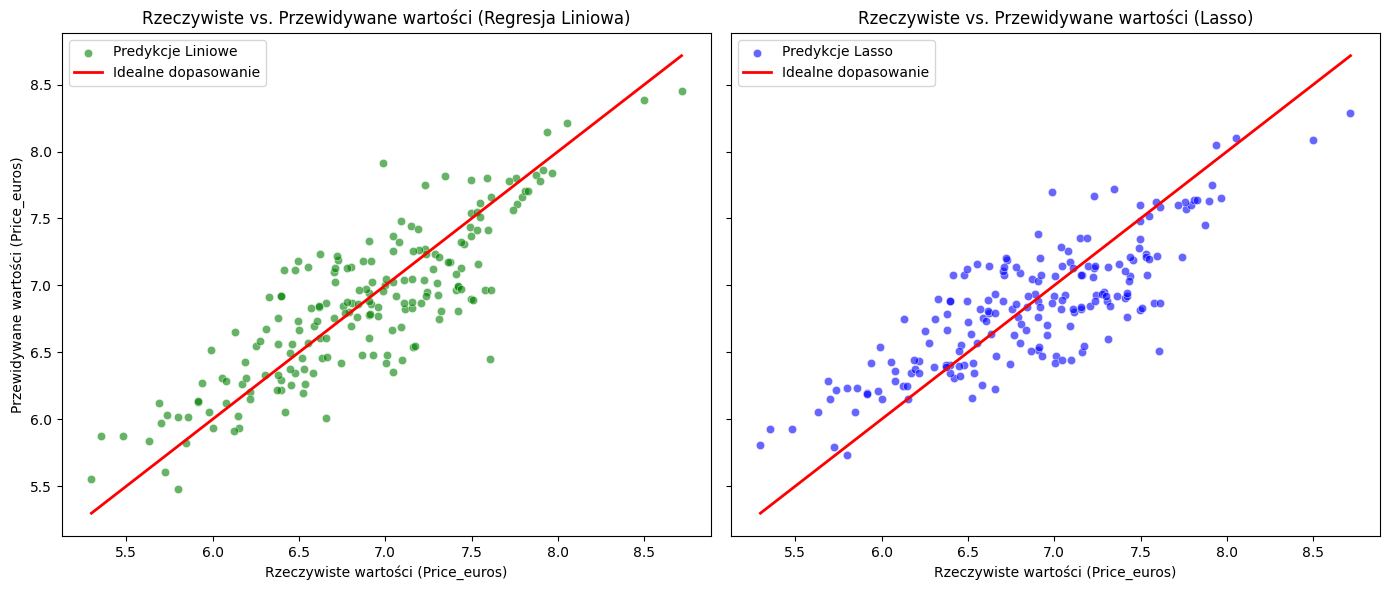

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True) 

# Wykres dla regresji liniowej
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.6, color='green', label='Predykcje Liniowe', ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[0].set_title("Rzeczywiste vs. Przewidywane wartości (Regresja Liniowa)")
axes[0].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[0].set_ylabel("Przewidywane wartości (Price_euros)")
axes[0].legend()

# Wykres dla modelu Lasso
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.6, color='blue', label='Predykcje Lasso', ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[1].set_title("Rzeczywiste vs. Przewidywane wartości (Lasso)")
axes[1].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[1].legend()

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

In [ ]:
# Oblicz reszty (różnice między rzeczywistymi a przewidywanymi wartościami)
residuals = y_test_reg - y_pred_reg

# Wykres reszt
''' 
Pokazuje różnice między rzeczywistymi a przewidywanymi wartościami, pomagając zidentyfikować wzorce 
np. czy błędy są losowe i czy nie ma systematycznych wzorców. 
Idealnie punkty powinny być rozrzucone równomiernie wokół linii zerowej.
'''
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_reg, y=residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', lw=2, label="Linia zerowa")
plt.title("Wykres reszt")
plt.xlabel("Przewidywane wartości (Price_euros)")
plt.ylabel("Reszty")
plt.legend()
plt.show()


In [9]:
# Histogram błędów (reszt)
''' 
Przedstawia rozkład błędów modelu, pozwalając ocenić, czy są one zgodne z założeniami regresji.
W regresji liniowej oczekujemy, że błędy mają rozkład zbliżony do normalnego, skoncentrowanego wokół zera.
'''
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', lw=2, label="Linia zerowa")
plt.title("Histogram błędów (reszt)")
plt.xlabel("Reszty")
plt.ylabel("Częstość")
plt.legend()
plt.show()

NameError: name 'residuals' is not defined

<Figure size 1000x600 with 0 Axes>

## 4. Wykres Sumaryczny Wartości SHAP

In [ ]:
# wyjaśniacz SHAP dla modelu regresji liniowej
regression_explainer = shap.LinearExplainer(regression_model, X_train_reg)
regression_shap_values = regression_explainer.shap_values(X_test_reg)

# wykres sumaryczny wartości SHAP
shap.summary_plot(regression_shap_values, X_test_reg, plot_type="bar")
plt.show()



In [ ]:
# wykres zależności dla cechy 'Ram'
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "Ram", regression_shap_values, X_test_reg,
    interaction_index=None, show=False
)
plt.title("Wykres zależności wartości SHAP dla 'Ram'")
plt.xlabel("Ram")
plt.ylabel("Wartości SHAP")

# dodanie trendu regresji (regplot z seaborn)
sns.regplot(x=X_test_reg['Ram'], y=regression_shap_values[:, X_test_reg.columns.get_loc("Ram")], 
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ci=None)

plt.show()

# wykres zależności dla cechy 'OS'
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "GPU_company", regression_shap_values, X_test_reg,
    interaction_index=None, show=False
)
plt.title("Wykres zależności wartości SHAP dla 'GPU_company'")
plt.xlabel("GPU_company")
plt.ylabel("Wartości SHAP")

# dodanie trendu regresji (regplot z seaborn)
sns.regplot(x=X_test_reg['GPU_company'], y=regression_shap_values[:, X_test_reg.columns.get_loc("GPU_company")], 
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ci=None)

plt.show()


## 5. Model klasyfikacji - Wartości Shapleya i interpretacja

In [ ]:
# Zakodowanie etykiet dla kolumny 'TypeName'
y_classification = model_data['TypeName'].astype('category').cat.codes
X_classification = model_data.drop(columns=['TypeName'])

# Podział danych na zbiory treningowy i testowy
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

# Resetowanie indeksów
X_test_cls = X_test_cls.reset_index(drop=True)

# Trenowanie modelu dla pełnego zestawu cech
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Inicjalizacja GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5
)

# Dopasowanie najlepszego modelu
grid_search.fit(X_train_cls, y_train_cls)
best_classifier = grid_search.best_estimator_

# Ocena dokładności na zbiorze testowym
y_pred_cls = best_classifier.predict(X_test_cls)
print("\nDokładność modelu klasyfikacyjnego:", accuracy_score(y_test_cls, y_pred_cls))

# Tworzenie próbki referencyjnej
background_top = X_train_cls.sample(100, random_state=42)

# Tworzenie wyjaśniacza SHAP z pełnym zestawem cech
classification_explainer = shap.TreeExplainer(best_classifier, background_top)

# Obliczenie wartości SHAP dla wszystkich klas na X_test_cls
shap_values = classification_explainer.shap_values(X_test_cls)

# Określenie liczby klas
if isinstance(shap_values, list):
    num_classes = len(shap_values)
else:
    num_classes = shap_values.shape[2] if len(shap_values.shape) == 3 else 1

# Wybór klasy do analizy
class_index = 0  # Możesz zmienić indeks klasy, jeśli chcesz analizować inną klasę

# Pobranie shap_values dla wybranej klasy
if isinstance(shap_values, list):
    shap_values_single_class = shap_values[class_index]
else:
    if num_classes > 1:
        shap_values_single_class = shap_values[:, :, class_index]
    else:
        shap_values_single_class = shap_values

# Konwersja shap_values_single_class do DataFrame z odpowiednimi nazwami kolumn
shap_values_single_class = pd.DataFrame(shap_values_single_class, columns=X_test_cls.columns)
shap_values_single_class = shap_values_single_class.reset_index(drop=True)

# Sprawdzenie i przycięcie shap_values_single_class, jeśli ma dodatkowe kolumny
if shap_values_single_class.shape[1] > X_test_cls.shape[1]:
    shap_values_single_class = shap_values_single_class.iloc[:, :X_test_cls.shape[1]]

# Wybór typu wykresu SHAP
plot_type = "dot"  # Zmień na "bar", jeśli chcesz wykres słupkowy

# Generowanie wykresu sumarycznego
plt.figure()
shap.summary_plot(shap_values_single_class.values, X_test_cls, plot_type=plot_type, max_display=10, show=False)
plt.subplots_adjust(bottom=0.3)  # Zwiększenie dolnego marginesu
fig = plt.gcf()
fig.suptitle("Wykres sumaryczny wartości SHAP", y=1.02)
fig.text(0.5, 0.01, "Wykres sumaryczny przedstawia wpływ każdej cechy na przewidywanie modelu.\n"
                    "Punkty reprezentują przykłady, a kolor wskazuje wartości cech (niebieski - niska wartość,\n"
                    "czerwony - wysoka wartość).", ha="center", fontsize=10)
plt.show()
plt.close()

# Wykres zależności dla wybranej cechy (np. 'Ram') dla jednej klasy
feature_to_plot = "Ram"  # Upewnij się, że ta cecha istnieje w X_test_cls
if feature_to_plot in X_test_cls.columns:
    # Wykres zależności SHAP
    plt.figure()
    shap.dependence_plot(feature_to_plot, shap_values_single_class.values, X_test_cls, interaction_index=None, show=False)
    plt.subplots_adjust(bottom=0.3)  # Zwiększenie dolnego marginesu
    fig = plt.gcf()
    fig.suptitle(f"Wykres zależności wartości SHAP dla '{feature_to_plot}'", y=1.02)
    fig.text(0.5, 0.01, f"Wykres zależności SHAP dla cechy '{feature_to_plot}' pokazuje, jak wpływa ona na\n"
                        f"przewidywania modelu, wraz z trendem wzajemnego oddziaływania.", ha="center", fontsize=10)
    plt.show()
    plt.close()
    
    # Wykres zależności z linią trendu
    plt.figure()
    sns.regplot(
        x=X_test_cls[feature_to_plot],
        y=shap_values_single_class[feature_to_plot],
        scatter_kws={'alpha': 0.5},
        line_kws={"color": "orange"},
        ci=None
    )
    plt.title(f"Wykres zależności wartości SHAP dla '{feature_to_plot}' z linią trendu")
    plt.xlabel(feature_to_plot)
    plt.ylabel("Wartości SHAP")
    plt.subplots_adjust(bottom=0.3)  # Zwiększenie dolnego marginesu
    plt.figtext(0.5, 0.01, f"Linia trendu na wykresie pokazuje ogólny kierunek wpływu cechy '{feature_to_plot}' na\n"
                            f"przewidywania modelu, co pomaga zrozumieć jej znaczenie.", ha="center", fontsize=10)
    plt.show()
    plt.close()
else:
    print(f"Cecha '{feature_to_plot}' nie istnieje w X_test_cls.")
